In [77]:
%matplotlib inline
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sqlite3
import os

plt.style.use ('ggplot')

In [78]:
city_flows_dfs = []
metro_flows_dfs = []

data_path = '/Users/anastasiaclark/irs_nyc_migration/data'
db = 'irsmig_county_database'
con = sqlite3.connect (os.path.join (data_path, db, "irs_migration_county.sqlite"))
metros = pd.read_csv (os.path.join (data_path, 'metros', 'metros_basic.csv'),
                      converters={'fips': str, 'co_code': str, 'cbsa_code': str})

years = ['2011_12', '2012_13', '2013_14', '2014_15']  # project years

# add here variables for other cities

# NYC counties
nyc = ['36005', '36047', '36061', '36081', '36085']

In [79]:
def get_flows_by_city(year, city):
    """ function to read in data from the database
    and select only flows for selected city

    :rtype: dataframe"""

    # read in inflow & outflow data and store it in a pandas dataframe
    table1 = 'outflow_{}'.format (year)
    table2 = 'inflow_{}'.format (year)

    # SQL query to select 
    # flows between, but not within counties
    df_out = pd.read_sql_query ("SELECT * from {} where {}.origin!={}.destination".format (table1, table1, table1), con)
    df_in = pd.read_sql_query ("SELECT * from {} where {}.origin!={}.destination".format (table2, table2, table2), con)

    # Make the index to be same for same records
    df_out['uid'] = df_out.origin + "_" + df_out.destination
    df_in['uid'] = df_in.origin + "_" + df_in.destination

    df_in.set_index ('uid', inplace=True)
    df_out.set_index ('uid', inplace=True)
    
    # select a subset of records between and not within city's counties
    city_in = df_in[(df_in['destination'].isin (city)) & (~df_in['origin'].isin (city))]
    city_out = df_out[(df_out['origin'].isin (city)) & (~df_out['destination'].isin (city))]
    
    
    to_city = city_in[['origin', 'co_orig_name', 'exemptions', 'st_orig_abbrv']].groupby (
        ['origin', 'co_orig_name', 'st_orig_abbrv']).sum ().sort_values ('exemptions', ascending=False).reset_index ()
    from_city = city_out[['destination', 'co_dest_name', 'st_dest_abbrv', 'exemptions']].groupby (
        ['destination', 'co_dest_name', 'st_dest_abbrv']).sum ().sort_values ('exemptions',
                                                                              ascending=False).reset_index ()
    to_city.rename (columns={'origin': 'co_fips', 'co_orig_name': 'co_name', 'exemptions': 'inflow' + year,
                             'st_orig_abbrv': 'state'}, inplace=True)
    from_city.rename (columns={'destination': 'co_fips', 'co_dest_name': 'co_name', 'st_dest_abbrv': 'state',
                               'exemptions': 'outflow' + year}, inplace=True)

    flows_city = to_city.merge (from_city, on=['co_fips', 'co_name', 'state'], how='outer')

    # merge metro areas info to nyc flows to determine which counties from these flows are urban
    flows_city = flows_city.merge (metros[['cbsa_code', 'cbsa_name', 'fips']], left_on='co_fips', right_on='fips',
                                   how='left').drop ('fips', 1)

    # add calculated columns
    flows_city['net_flow' + year] = flows_city['inflow' + year] - flows_city['outflow' + year]
    flows_city['in_ratio' + year] = flows_city['inflow' + year] / flows_city['outflow' + year]
    return flows_city

In [80]:
def get_flows_by_metro(year, metro):
    """ function to read in data from the database
    and summarize it for selected metro area

    :param year: The year period from the database in the format 'yyyy_yy'
    :param metro: Name of the metro area; 
            can pass only part of the name if the part is unique for metros
            Ex: 'New York' for New York-Newark-Jersey City, NY-NJ-PA
    :return: dataframe of flows by specified metro area
    :rtype: dataframe"""

    # read in inflow & outflow data and store it in a pandas dataframe
    table1 = 'outflow_{}'.format (year)
    table2 = 'inflow_{}'.format (year)

    # SQL query to select 
    # flows between, but not within counties
    df_out = pd.read_sql_query ("SELECT * from {} where {}.origin!={}.destination".format (table1, table1, table1), con)
    df_in = pd.read_sql_query ("SELECT * from {} where {}.origin!={}.destination".format (table2, table2, table2), con)

    # Make the index to be same for same records
    df_out['uid'] = df_out.origin + "_" + df_out.destination
    df_in['uid'] = df_in.origin + "_" + df_in.destination

    df_in.set_index ('uid', inplace=True)
    df_out.set_index ('uid', inplace=True)

    # merge inflow and outflowbtabvles into a single flows table so that 
    # it can be aggregated to metro area flows;
    
    # drop a column in each table 
    df_in.drop ('co_orig_name', 1, inplace=True)
    df_out.drop ('co_dest_name', 1, inplace=True)

    # get inflow and outflow into a single table and since most of the records exist in both tables, drop duplicates
    flows = pd.concat ([df_in, df_out], axis=0).drop_duplicates (
        subset=['origin', 'destination', 'returns', 'exemptions'])

    # some records don't match in inflow and outflow tables
    # and therefore they don't get dropped as duplicates
    # check if there are any records with duplicated indexes
    if len (flows[flows.index.duplicated ()]) > 0:
        non_matching = flows.index[flows.index.duplicated ()]

        dfs = []
        for ix in non_matching:
            a = flows.loc[ix, ['exemptions', 'returns']]
            d = a.diff ()
            dfs.append (d)
        df = pd.concat (dfs)

        print ('Summary of the unmatched inflow and outflow tables for year:', year)
        print ('Max difference in exemptions', df.exemptions.max ())
        print ('Min difference in exemptions', df.exemptions.min ())
        print ('Max difference in returns', df.returns.max ())
        print ('Min difference in returns', df.returns.min ())
        print (len (flows))
        flows = flows[~flows.index.duplicated (keep='first')]
        print (len (flows))

    # merge metro area information twice: for county of origin and for county of destination
    flows = flows.merge (metros[['fips', 'cbsa_code', 'cbsa_name']], left_on='destination', right_on='fips',
                         how='left').drop ('fips', 1).rename (
        columns={'cbsa_name': 'dest_name', 'cbsa_code': 'dest_cbsa'})
    flows = flows.merge (metros[['fips', 'cbsa_code', 'cbsa_name']], left_on='origin', right_on='fips',
                         how='left').drop ('fips', 1).rename (
        columns={'cbsa_name': 'orig_name', 'cbsa_code': 'orig_cbsa'})

    # groupby metro of origin and destination to get flows b/n metro areas
    flows_metro = flows[['orig_cbsa', 'orig_name', 'dest_cbsa', 'dest_name', 'returns', 'exemptions']].groupby (
        ['orig_cbsa', 'orig_name', 'dest_cbsa', 'dest_name']).sum ().reset_index ()

    metro_in = flows_metro[(flows_metro.dest_name.str.contains (metro)) & (
        ~flows_metro.orig_name.str.contains (metro))].copy ()  # get all the inter-metro inflows
    metro_out = flows_metro[(flows_metro.orig_name.str.contains (metro)) & (
        ~flows_metro.dest_name.str.contains (metro))].copy ()  # get all the inter-metro outflows

    # rename columns for merging inflow and outflow tables together
    metro_in = metro_in[['orig_cbsa', 'orig_name', 'exemptions']].rename (
        columns={'orig_cbsa': 'cbsa_code', 'orig_name': 'cbsa_name', 'exemptions': 'inflow' + year})
    metro_out = metro_out[['dest_cbsa', 'dest_name', 'exemptions']].rename (
        columns={'dest_cbsa': 'cbsa_code', 'dest_name': 'cbsa_name', 'exemptions': 'outflow' + year})

    # merge inflow and outflow by metro into a single table
    by_metro = pd.merge (metro_in, metro_out, on=['cbsa_code', 'cbsa_name'], how='outer')

    # add calculated columns
    by_metro['net_flow' + year] = by_metro['inflow' + year] - by_metro['outflow' + year]
    return by_metro

In [81]:
# this part is specific to NYC/NY metro , but can be repeated for any other city/metro

# run the functions to get inflow/outflow data for New York city and for NY metro area
# for each year and append the results to a list
for year in years:
    city_flows_dfs.append (get_flows_by_city (year, nyc))

for year in years:
    metro_flows_dfs.append (get_flows_by_metro (year, 'New York'))

# merge all years dfs for NYC (Metro) from the list into a single df
city_flows=reduce(lambda x, y: pd.merge(x, y, on = ['co_fips', 'co_name', 'state', 'cbsa_code', 'cbsa_name'], how='outer'), city_flows_dfs)
metro_flows=reduce(lambda x, y: pd.merge(x, y, on = ['cbsa_code', 'cbsa_name'], how='outer'), metro_flows_dfs)

('Summary of the unmatched inflow and outflow tables for year:', '2014_15')
('Max difference in exemptions', 7.0)
('Min difference in exemptions', -6.0)
('Max difference in returns', 2.0)
('Min difference in returns', -2.0)
54573
54479


In [82]:
city_flows.head()

,co_fips,co_name,state,inflow2011_12,outflow2011_12,cbsa_code,cbsa_name,net_flow2011_12,in_ratio2011_12,inflow2012_13,...,net_flow2012_13,in_ratio2012_13,inflow2013_14,outflow2013_14,net_flow2013_14,in_ratio2013_14,inflow2014_15,outflow2014_15,net_flow2014_15,in_ratio2014_15
0,36059,Nassau County,NY,13995.0,22803.0,35620,"New York-Newark-Jersey City, NY-NJ-PA",-8808.0,0.613735,14458.0,...,-10036.0,0.590267,13877.0,25204.0,-11327.0,0.550587,11900.0,20316.0,-8416.0,0.585745
1,59000,Other flows - Different State,DS,13850.0,16808.0,NaN,NaN,-2958.0,0.824012,14062.0,...,-3319.0,0.809044,21728.0,25405.0,-3677.0,0.855265,19743.0,23807.0,-4064.0,0.829294
2,36119,Westchester County,NY,11588.0,16967.0,35620,"New York-Newark-Jersey City, NY-NJ-PA",-5379.0,0.682973,10806.0,...,-7608.0,0.586836,10438.0,17173.0,-6735.0,0.607815,9048.0,13986.0,-4938.0,0.646933
3,36103,Suffolk County,NY,8838.0,9785.0,35620,"New York-Newark-Jersey City, NY-NJ-PA",-947.0,0.903219,7493.0,...,-2143.0,0.777605,7056.0,9271.0,-2215.0,0.761083,5837.0,8171.0,-2334.0,0.714356
4,34017,Hudson County,NJ,6308.0,8761.0,35620,"New York-Newark-Jersey City, NY-NJ-PA",-2453.0,0.720009,6270.0,...,-2871.0,0.685921,5729.0,8818.0,-3089.0,0.649694,4709.0,7273.0,-2564.0,0.647463


In [83]:
metro_flows.head()

,cbsa_code,cbsa_name,inflow2011_12,outflow2011_12,net_flow2011_12,inflow2012_13,outflow2012_13,net_flow2012_13,inflow2013_14,outflow2013_14,net_flow2013_14,inflow2014_15,outflow2014_15,net_flow2014_15
0,10420,"Akron, OH",88.0,97.0,-9.0,134.0,106.0,28.0,60.0,36.0,24.0,67.0,NaN,NaN
1,10500,"Albany, GA",24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10580,"Albany-Schenectady-Troy, NY",2402.0,3826.0,-1424.0,2472.0,3998.0,-1526.0,1882.0,3236.0,-1354.0,1543.0,2626.0,-1083.0
3,10740,"Albuquerque, NM",149.0,132.0,17.0,104.0,157.0,-53.0,107.0,79.0,28.0,67.0,NaN,NaN
4,10900,"Allentown-Bethlehem-Easton, PA-NJ",6393.0,8676.0,-2283.0,5629.0,8032.0,-2403.0,4065.0,7727.0,-3662.0,3288.0,6069.0,-2781.0


In [84]:
# create ranks for inflow and outflow for each year
# since columns names are the same in metro and city tables, resuse the loop for both tables
# while calculating ranks
city_flows.fillna (0, inplace=True)
metro_flows.fillna (0, inplace=True)
for col in [c for c in city_flows.columns if 'inflow' in c or 'outflow' in c]:
    yr = col[-7:]
    in_out = col[0:2]
    city_flows['{}_rank{}'.format (in_out, yr)] = city_flows[col].rank (method='dense', ascending=False)
    metro_flows['{}_rank{}'.format (in_out, yr)] = metro_flows[col].rank (method='dense', ascending=False)

In [85]:
# write the resulting data out to use for mapping in QGIS 
# city_flows.to_csv('yrs_2011_2015_nyc_mig_by_county.csv')
# metro_flows.to_csv('yrs_2011_2015_ny_mig_by_metro.csv')

In [86]:
city_flows.head()

,co_fips,co_name,state,inflow2011_12,outflow2011_12,cbsa_code,cbsa_name,net_flow2011_12,in_ratio2011_12,inflow2012_13,...,net_flow2014_15,in_ratio2014_15,in_rank2011_12,ou_rank2011_12,in_rank2012_13,ou_rank2012_13,in_rank2013_14,ou_rank2013_14,in_rank2014_15,ou_rank2014_15
0,36059,Nassau County,NY,13995.0,22803.0,35620,"New York-Newark-Jersey City, NY-NJ-PA",-8808.0,0.613735,14458.0,...,-8416.0,0.585745,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0
1,59000,Other flows - Different State,DS,13850.0,16808.0,0,0,-2958.0,0.824012,14062.0,...,-4064.0,0.829294,2.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0
2,36119,Westchester County,NY,11588.0,16967.0,35620,"New York-Newark-Jersey City, NY-NJ-PA",-5379.0,0.682973,10806.0,...,-4938.0,0.646933,3.0,2.0,3.0,2.0,3.0,3.0,3.0,3.0
3,36103,Suffolk County,NY,8838.0,9785.0,35620,"New York-Newark-Jersey City, NY-NJ-PA",-947.0,0.903219,7493.0,...,-2334.0,0.714356,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
4,34017,Hudson County,NJ,6308.0,8761.0,35620,"New York-Newark-Jersey City, NY-NJ-PA",-2453.0,0.720009,6270.0,...,-2564.0,0.647463,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


# What was the number of in-migrants, out-migrants, and net change for domestic migration for NYC / NYM (year by year and cumulative)?

In [87]:
foreign=['57005','57009','57001','57003','57007']

In [88]:
domestic_city_flows=city_flows[~city_flows['co_fips'].isin (foreign)]
foreign_city_flows=city_flows[city_flows['co_fips'].isin (foreign)]
# to do: re-think how the metro flows in generated--unable to separate into domestic and foreign in current form

In [89]:
foreign_city_flows

,co_fips,co_name,state,inflow2011_12,outflow2011_12,cbsa_code,cbsa_name,net_flow2011_12,in_ratio2011_12,inflow2012_13,...,net_flow2014_15,in_ratio2014_15,in_rank2011_12,ou_rank2011_12,in_rank2012_13,ou_rank2012_13,in_rank2013_14,ou_rank2013_14,in_rank2014_15,ou_rank2014_15
11,57003,Foreign - Puerto Rico,FR,3277.0,3630.0,0,0,-353.0,0.902755,2189.0,...,-259.0,0.535009,12.0,15.0,16.0,42.0,76.0,63.0,86.0,69.0
13,57001,Foreign - Overseas,FR,2726.0,7343.0,0,0,-4617.0,0.371238,2926.0,...,-3794.0,0.430843,14.0,7.0,11.0,8.0,10.0,8.0,10.0,6.0
63,57005,Foreign - APO/FPO ZIPs,FR,601.0,586.0,0,0,15.0,1.025597,576.0,...,24.0,1.060302,63.0,80.0,63.0,94.0,64.0,93.0,65.0,88.0
363,57009,Foreign - Other flows,FR,16.0,32.0,0,0,-16.0,0.500000,35.0,...,-25.0,0.968944,242.0,263.0,228.0,281.0,188.0,216.0,35.0,50.0
441,57007,Foreign - US Virgin Islands,FR,0.0,13.0,0,0,0.0,0.000000,0.0,...,0.0,0.000000,249.0,281.0,253.0,281.0,215.0,225.0,191.0,195.0


In [90]:
def get_total_flows(df):
  in_mig=pd.DataFrame(df[['inflow2011_12','inflow2012_13','inflow2013_14','inflow2014_15']].sum(axis=0), columns=['in_migration']).reset_index().rename(columns={'index':'years'})
  in_mig['years']=in_mig.years.apply(lambda x :x[-7:])
  out_mig=pd.DataFrame(df[['outflow2011_12','outflow2012_13','outflow2013_14','outflow2014_15']].sum(axis=0), columns=['out_migration']).reset_index().rename(columns={'index':'years'})
  out_mig['years']=out_mig.years.apply(lambda x :x[-7:])
  df_total=pd.merge(in_mig,out_mig, on='years')
  df_total['net_migration']=df_total['in_migration']-df_total['out_migration']
  df_total.set_index('years',inplace=True)  
  return df_total

In [91]:
#get_total_flows(city_flows)

In [92]:
total_city_dom=get_total_flows(domestic_city_flows)
total_city_dom

,in_migration,out_migration,net_migration
years,,,
2011_12,180459.0,245886.0,-65427.0
2012_13,173813.0,257056.0,-83243.0
2013_14,161752.0,247407.0,-85655.0
2014_15,140397.0,202264.0,-61867.0


In [93]:
total_city_foreign=get_total_flows(foreign_city_flows)
total_city_foreign

,in_migration,out_migration,net_migration
years,,,
2011_12,6620.0,11604.0,-4984.0
2012_13,5726.0,8103.0,-2377.0
2013_14,3850.0,7454.0,-3604.0
2014_15,4372.0,8426.0,-4054.0


In [94]:
total_city_dom.net_migration.sum()

-296192.0

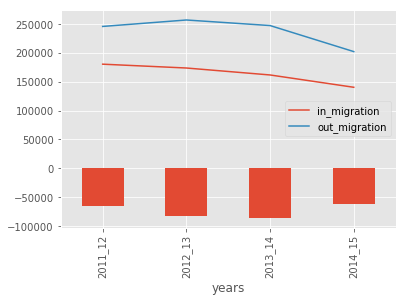

In [95]:
ax=total_city_dom[['in_migration','out_migration']].plot()
total_city_dom['net_migration'].plot(kind='bar', ax=ax)
# to do adjust and turn into function

In [96]:
# get top senders/receivers
# counties that were ranked as top 5 (top 10) senders/receivers in any of the four years periods
all_time_top_senders = \
    domestic_city_flows[
        (domestic_city_flows['in_rank2011_12'] < 6) | (domestic_city_flows['in_rank2012_13'] < 6) | (
            domestic_city_flows['in_rank2013_14'] < 6) | (
            domestic_city_flows['in_rank2014_15'] < 6)].copy()
all_time_top_senders['county'] = all_time_top_senders['co_name'] + "," + all_time_top_senders['state']
all_time_top_senders = all_time_top_senders.set_index ('county').drop (['co_name', 'state'], 1)

all_time_top_receivers = \
    domestic_city_flows[
        (domestic_city_flows['ou_rank2011_12'] < 10) | (domestic_city_flows['ou_rank2012_13'] < 10) | (
            domestic_city_flows['ou_rank2013_14'] < 10) | (domestic_city_flows['ou_rank2014_15'] < 10)].copy()
all_time_top_receivers['county'] = all_time_top_receivers['co_name'] + "," + all_time_top_receivers['state']
all_time_top_receivers = all_time_top_receivers.set_index ('county').drop (['co_name', 'state'], 1)

In [97]:
all_time_top_senders.head()

,co_fips,inflow2011_12,outflow2011_12,cbsa_code,cbsa_name,net_flow2011_12,in_ratio2011_12,inflow2012_13,outflow2012_13,net_flow2012_13,...,net_flow2014_15,in_ratio2014_15,in_rank2011_12,ou_rank2011_12,in_rank2012_13,ou_rank2012_13,in_rank2013_14,ou_rank2013_14,in_rank2014_15,ou_rank2014_15
county,,,,,,,,,,,,,,,,,,,,,
"Nassau County,NY",36059,13995.0,22803.0,35620,"New York-Newark-Jersey City, NY-NJ-PA",-8808.0,0.613735,14458.0,24494.0,-10036.0,...,-8416.0,0.585745,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0
"Other flows - Different State,DS",59000,13850.0,16808.0,0,0,-2958.0,0.824012,14062.0,17381.0,-3319.0,...,-4064.0,0.829294,2.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0
"Westchester County,NY",36119,11588.0,16967.0,35620,"New York-Newark-Jersey City, NY-NJ-PA",-5379.0,0.682973,10806.0,18414.0,-7608.0,...,-4938.0,0.646933,3.0,2.0,3.0,2.0,3.0,3.0,3.0,3.0
"Suffolk County,NY",36103,8838.0,9785.0,35620,"New York-Newark-Jersey City, NY-NJ-PA",-947.0,0.903219,7493.0,9636.0,-2143.0,...,-2334.0,0.714356,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
"Hudson County,NJ",34017,6308.0,8761.0,35620,"New York-Newark-Jersey City, NY-NJ-PA",-2453.0,0.720009,6270.0,9141.0,-2871.0,...,-2564.0,0.647463,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [98]:
def plot_ranks(df, cols, title):

    """function to plot change in ranks over time
    :param df: dataframe to plot
    :param cols: a list of colum ranks to plot 
    :param title: Tile to display
    """
    df_ranks=df[cols]
    df_ranks.columns = [col[-7:] if 'rank' in col else col for col in df_ranks.columns]
    ax = df_ranks.T.plot (marker='o')
    ax.invert_yaxis ()
    ax.yaxis.set_major_locator (ticker.MaxNLocator (integer=True)) # display only whole numbers
    ax.legend (bbox_to_anchor=(1.07, 1), loc='upper left')
    ax.set_xlabel ('Year')
    ax.set_ylabel ('Rank')
    ax2 = ax.twinx () # get second y axis on the right
    ax2.yaxis.set_major_locator (ticker.MaxNLocator (integer=True))
    ax2.set_ylim (ax.get_ylim ())
    plt.title (title)
    plt.show ()

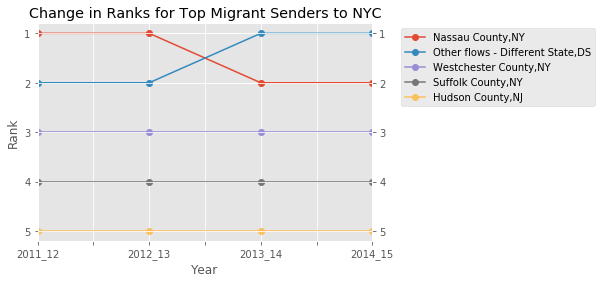

In [99]:
plot_ranks (all_time_top_senders,['in_rank2011_12', 'in_rank2012_13', 'in_rank2013_14', 'in_rank2014_15'], 'Change in Ranks for Top Migrant Senders to NYC')

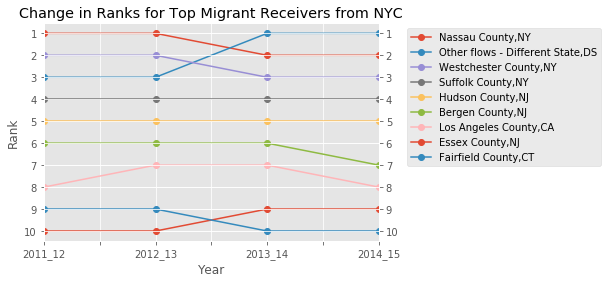

In [100]:
plot_ranks (all_time_top_receivers,['ou_rank2011_12', 'ou_rank2012_13', 'ou_rank2013_14', 'ou_rank2014_15'], 'Change in Ranks for Top Migrant Receivers from NYC')
# this is what I meant by showing ten records with default colors